In [12]:
"""
-------------------------------------------Imports-------------------------------------------
"""
import pandas as pd
import keras
import seaborn as sns
import tensorflow
from keras import layers, regularizers, Input, Model
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder

## Variables

In [13]:
"""
-------------------------------------------Variables--------------------------------
"""
# -------- Pandas Dataframe
df = pd.read_csv("input/dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv")

# columns
columns = df.columns.tolist()

# categorized columns
nominal = [col for col in columns if df[col].dtype == 'object']
discrete = [col for col in columns if df[col].dtype == 'int64']
continuous = [col for col in columns if df[col].dtype == 'float']

# categorized dataframe
df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

#------------- enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# -------- Balanced subset
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced=pd.concat([df_class_1_subset, df_class_0])

C:\Users\faiza\AppData\Local\Temp\ipykernel_44176\105816632.py:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("input/dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv")


## Explore

In [14]:
print(df.info())
print(df_class_1.shape)
print(df_class_0.shape)
print(df_class_1_subset.shape)
print(df_balanced.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkSeqID                           668522 non-null  int64  
 1   stime                             668522 non-null  float64
 2   flgs                              668522 non-null  object 
 3   flgs_number                       668522 non-null  int64  
 4   proto                             668522 non-null  object 
 5   proto_number                      668522 non-null  int64  
 6   saddr                             668522 non-null  object 
 7   sport                             668522 non-null  object 
 8   daddr                             668522 non-null  object 
 9   dport                             668522 non-null  object 
 10  pkts                              668522 non-null  int64  
 11  bytes                             668522 non-null  i

In [15]:
for col in df:
    print(df[col].value_counts(), '\n')

pkSeqID
3000001    1
3445695    1
3445677    1
3445678    1
3445679    1
          ..
3222843    1
3222844    1
3222845    1
3222846    1
3668522    1
Name: count, Length: 668522, dtype: int64 

stime
1.528099e+09    29
1.528099e+09    28
1.528099e+09    28
1.528099e+09    27
1.528099e+09    27
                ..
1.526345e+09     1
1.526345e+09     1
1.526345e+09     1
1.526345e+09     1
1.529381e+09     1
Name: count, Length: 88102, dtype: int64 

flgs
e        654807
eU        11159
e s        2331
e d         113
e g          99
e &           5
e   t         4
e *           3
e  D          1
Name: count, dtype: int64 

flgs_number
1    654807
6     11159
2      2331
3       113
5        99
7         5
8         4
4         3
9         1
Name: count, dtype: int64 

proto
udp          592145
tcp           67202
icmp           9030
arp             137
ipv6-icmp         8
Name: count, dtype: int64 

proto_number
3    592145
1     67202
4      9030
2       137
5         8
Name: count, dt

## Transform Data

### Normalization

Min is 0
Max is 1
x is an element of [0,1]

before normalizing: stime
count    6.685220e+05
mean     1.527874e+09
std      5.722060e+05
min      1.526344e+09
25%      1.528099e+09
50%      1.528099e+09
75%      1.528099e+09
max      1.529381e+09
Name: stime, dtype: float64


after normalizing: stime
count    668522.000000
mean          0.503736
std           0.188427
min           0.000000
25%           0.578020
50%           0.578024
75%           0.578025
max           1.000000
Name: stime, dtype: float64


before normalizing: ltime
count    6.685220e+05
mean     1.527874e+09
std      5.722058e+05
min      1.526344e+09
25%      1.528099e+09
50%      1.528099e+09
75%      1.528099e+09
max      1.529382e+09
Name: ltime, dtype: float64


after normalizing: ltime
count    668522.000000
mean          0.503540
std           0.188375
min           0.000000
25%           0.577803
50%           0.577808
75%           0.577809
max           1.000000
Name: ltime, dtype: float64


before normalizing: dur
count    668522.000000
mean       

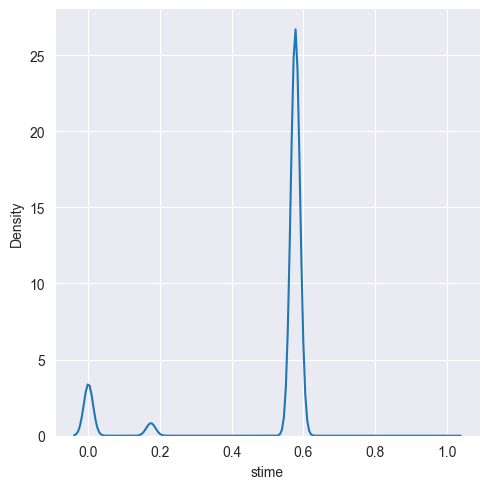

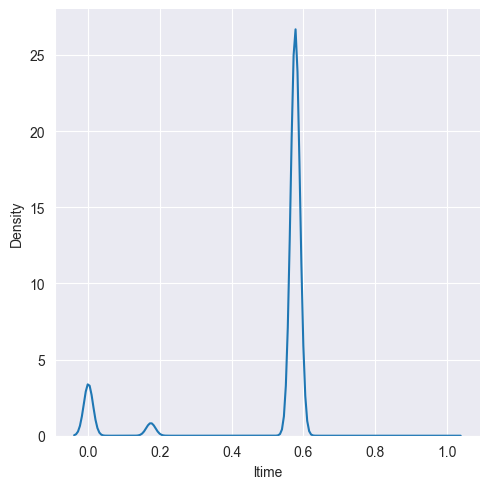

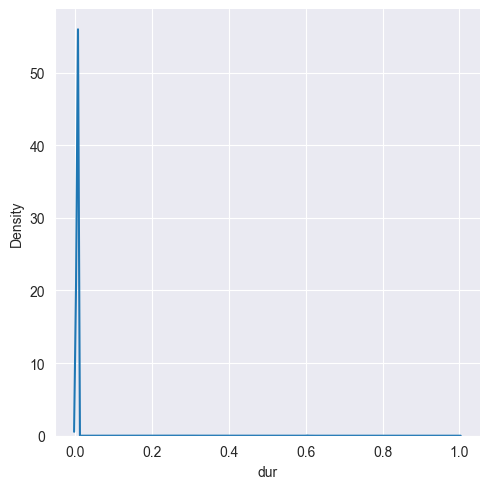

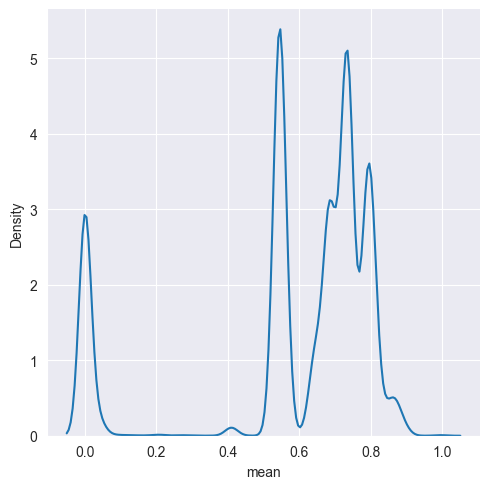

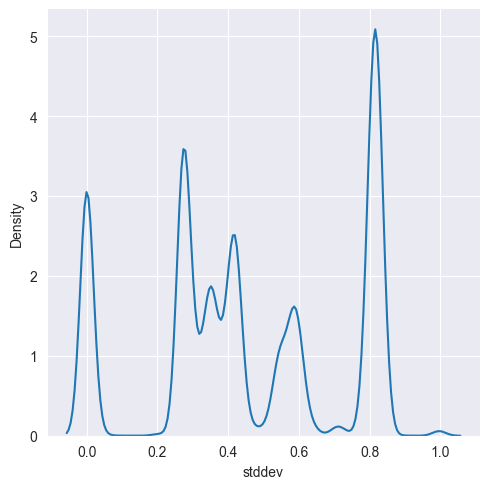

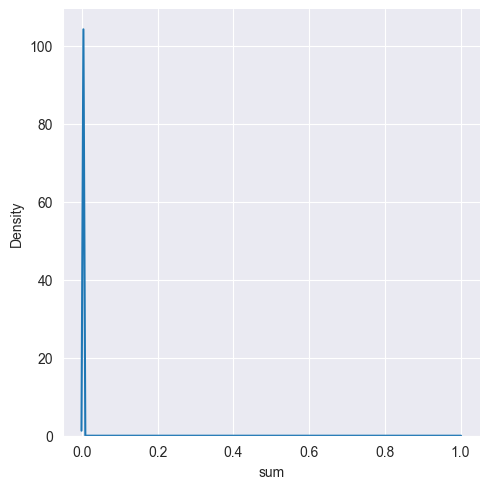

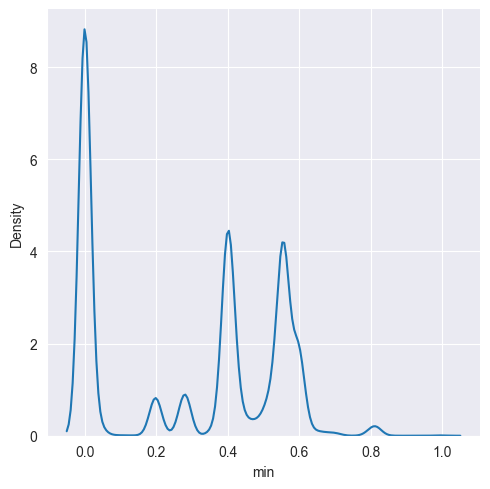

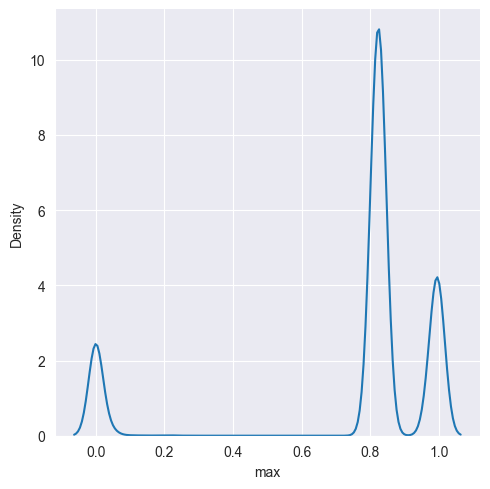

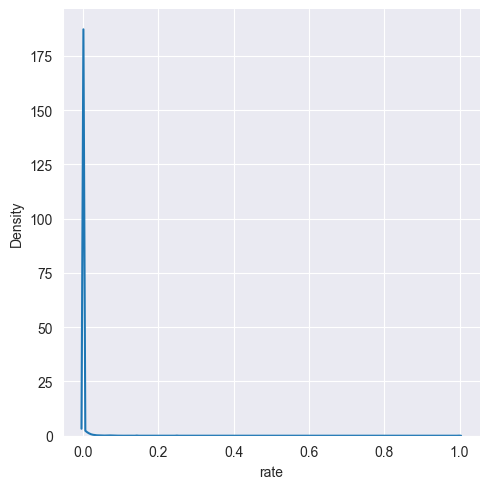

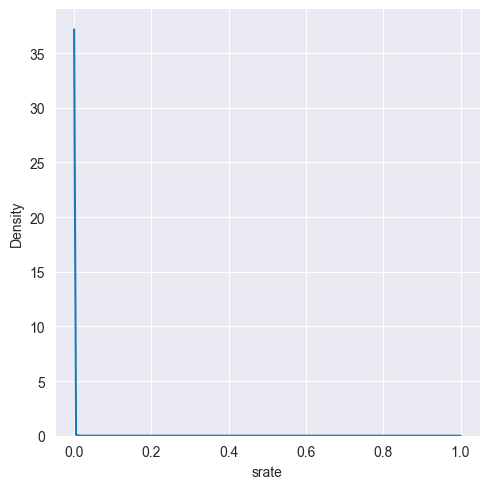

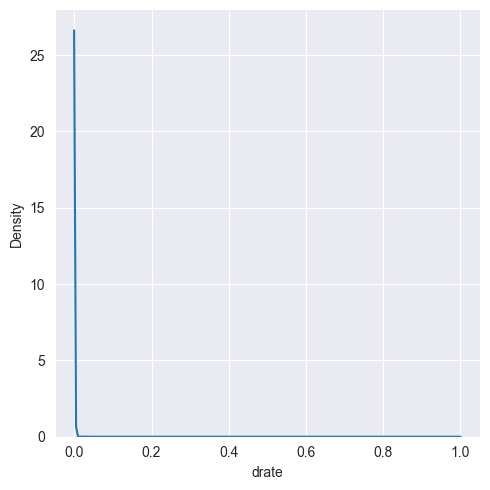

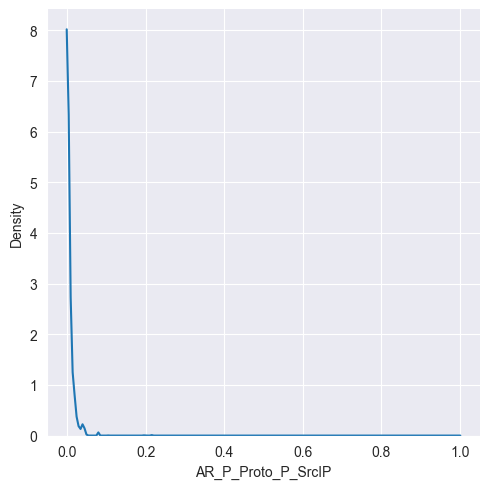

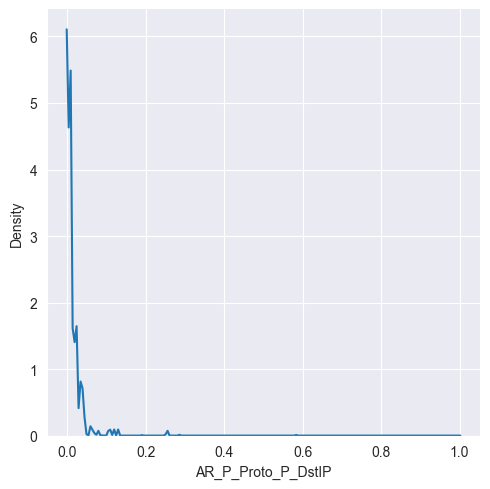

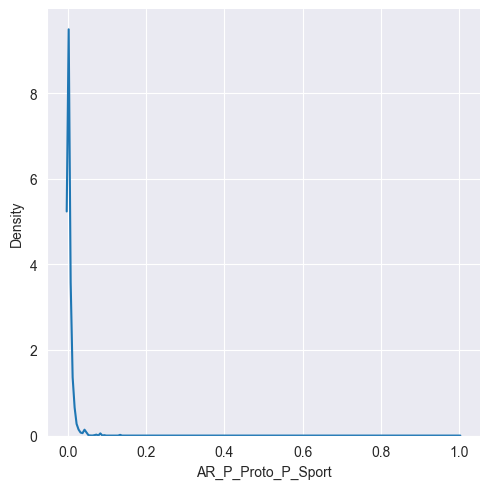

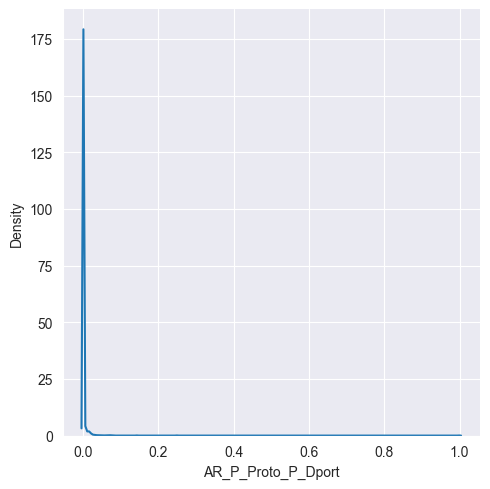

In [16]:
_scaler = MinMaxScaler()
for _col in continuous:
    print(f'before normalizing: {_col}', df[_col].describe(), '\n', sep='\n')
    df[_col] = _scaler.fit_transform(df[_col].values.reshape(-1, 1))
    print(f'after normalizing: {_col}', df[_col].describe(), '\n', sep='\n')
    print(sns.displot(data=df, x=_col, kind='kde'))

### Standardization

mean is 0
standard deviation is 1

In [17]:
_scaler = StandardScaler()
for _col in discrete:
    print(f'before standardizing: {_col}', df[_col].value_counts(), '\n', sep='\n')
    df[_col] = _scaler.fit_transform(df[_col].values.reshape(-1, 1))
    print(f'after standardizing: {_col}', df[_col].value_counts(), '\n', sep='\n')

before standardizing: pkSeqID
pkSeqID
3000001    1
3445695    1
3445677    1
3445678    1
3445679    1
          ..
3222843    1
3222844    1
3222845    1
3222846    1
3668522    1
Name: count, Length: 668522, dtype: int64


after standardizing: pkSeqID
pkSeqID
-1.732048    1
 0.577418    1
 0.577325    1
 0.577330    1
 0.577336    1
            ..
-0.577341    1
-0.577336    1
-0.577330    1
-0.577325    1
 1.732048    1
Name: count, Length: 668522, dtype: int64


before standardizing: flgs_number
flgs_number
1    654807
6     11159
2      2331
3       113
5        99
7         5
8         4
4         3
9         1
Name: count, dtype: int64


after standardizing: flgs_number
flgs_number
-0.136293     654807
 7.608529      11159
 1.412672       2331
 2.961636        113
 6.059565         99
 9.157493          5
 10.706458         4
 4.510600          3
 12.255422         1
Name: count, dtype: int64


before standardizing: proto_number
proto_number
3    592145
1     67202
4      9030
2

### Enumerate nominal columns

In [18]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n',  sep='\n')

before enumerating: flgs
flgs
e        654807
eU        11159
e s        2331
e d         113
e g          99
e &           5
e   t         4
e *           3
e  D          1
Name: count, dtype: int64


after enumerating: flgs
flgs
0    654807
8     11159
7      2331
5       113
6        99
3         5
1         4
4         3
2         1
Name: count, dtype: int64


before enumerating: proto
proto
udp          592145
tcp           67202
icmp           9030
arp             137
ipv6-icmp         8
Name: count, dtype: int64


after enumerating: proto
proto
4    592145
3     67202
1      9030
0       137
2         8
Name: count, dtype: int64


before enumerating: saddr
saddr
192.168.100.147              182905
192.168.100.148              167582
192.168.100.150              161085
192.168.100.149              147091
192.168.100.5                  5029
192.168.100.3                  4673
192.168.100.6                    38
192.168.100.7                    30
192.168.100.4                    1

## Auto Encoder

### Baseline
latent space dimension = 22
1 hidden layer

In [19]:
# TODO: Set up the encoder to compute the reconstruction error
# This is the size of our encoded representations
encoding_dim = 30  # compression factor of ~2/3 per layer, assuming the input is 45 floats

# This is our input
Inputs = keras.Input(shape=(45,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(Inputs)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(45, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(Inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Stratify

In [21]:
def stratify(X=None, y=None, size=None):
    df = pd.read_csv('input/dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv')
    if not X and not y and size:
        X=df.drop(columns=["attack"])[size:]
        y=df['attack'][size:]
    sss= StratifiedShuffleSplit(n_splits=5, random_state=0)
    sss.get_n_splits(X, y)
    return sss.split(X, y)

splits = stratify(size=10000)
stratified_data = {}
for i, (Xtr, Xte) in enumerate(splits):
    stratified_data[i]={'train': Xtr,
                        'test': Xte}

C:\Users\faiza\AppData\Local\Temp\ipykernel_44176\501179495.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('input/dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv')
